In [1]:
import argparse
import sys, os
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/stylegan2'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/gan/'))

from gan.gan_model import cont_style_munit_enc
from models.munit.enc_dec import MunitEncoder
from parameters.dataset import DatasetParameters
from parameters.deformation import DeformationParameters
from parameters.gan import GanParameters, MunitParameters
import albumentations
from albumentations.pytorch.transforms import ToTensor as AlbToTensor
from dataset.cardio_dataset import ImageMeasureDataset
from torch.utils import data
from transforms_utils.transforms import MaskToMeasure
import numpy as np
from transforms_utils.transforms import MeasureToMask, ToNumpy, NumpyBatch, ToTensor, MaskToMeasure, ResizeMask
from dataset.lazy_loader import LazyLoader, W300DatasetLoader, CelebaWithKeyPoints, Celeba
from dataset.toheatmap import ToHeatMap, heatmap_to_measure
from modules.hg import hg2, final_preds_untransformed, hg8, hg4, HG_softmax2020

In [2]:
from dataset.probmeasure import ProbabilityMeasureFabric, ProbabilityMeasure, UniformMeasure2DFactory, \
UniformMeasure2D01
from torch import nn
from modules.linear_ot import SOT, PairwiseDistance

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
from dataset.cardio_dataset import ImageMeasureDataset
from dataset.probmeasure import ProbabilityMeasure, ProbabilityMeasureFabric
from geomloss import SamplesLoss

In [5]:
import torch
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.set_device(device)

cuda:2


In [6]:
def imgs_with_mask(imgs, mask, color=[1.0,1.0,1.0]):
    # mask = torch.cat([mask, mask, mask], dim=1)
    mask = mask[:, 0, :, :]
    res: Tensor = imgs.cpu().detach()
    res = res.permute(0, 2, 3, 1)
    res[mask > 0.00001, :] = torch.tensor(color, dtype=torch.float32)
    res = res.permute(0, 3, 1, 2)
    return res

In [7]:
g_transforms: albumentations.DualTransform = albumentations.Compose([
        MeasureToMask(size=256),
        ToNumpy(),
        NumpyBatch(albumentations.ElasticTransform(p=1, alpha=150, alpha_affine=1, sigma=10)),
        NumpyBatch(albumentations.ShiftScaleRotate(p=1, rotate_limit=10)),
        ToTensor(device),
        MaskToMeasure(size=256, padding=140),
    ])

In [8]:
class Samples_Loss(nn.Module):
    def __init__(self, blur=.01, scaling=.9, diameter=None, border=None, p: int = 2):
        super(Samples_Loss, self).__init__()
        self.border = border
        self.loss = SamplesLoss("sinkhorn", blur=blur, scaling=scaling, debias=False, diameter=diameter, p=p)
        # self.pot = SamplesLoss("sinkhorn", blur=blur, scaling=scaling, debias=False, potentials=True)

    def forward(self, m1: ProbabilityMeasure, m2: ProbabilityMeasure):
        batch_loss = self.loss(m1.probability, m1.coord, m2.probability, m2.coord)
        return batch_loss


In [9]:
def handmadew1(m1,m2):
    lambd = 0.002
    with torch.no_grad():
        P = SOT(200, lambd).forward(m1, m2)
        print("RAVNOMERNAYA MERA", P[0])
        M = PairwiseDistance()(m1.coord, m2.coord).sqrt()
        print("L2 cherez PAIRWISE: " , M[0, 10,20])
        print("L2 v ruchnuu: ", (m1.coord[0, 10] - m2.coord[0, 20]).pow(2).sum().sqrt())
    return (M * P).sum(dim=(1,2)) / 2 # (2 * m1.coord.shape[1])

In [10]:
W1 = Samples_Loss(p=1)

In [11]:
W300DatasetLoader.test_batch_size = 16

In [12]:
def test(encoder):
    sum_loss = 0
#     was_loss = 0
    for i, batch in enumerate(LazyLoader.w300().test_loader):
        data = batch['data'].to(device)
        landmarks = batch["meta"]["keypts_normalized"].cuda()
        landmarks[landmarks > 1] = 0.99999
        print(landmarks.max())
        content = heatmap_to_measure(encoder(data))[0]
        pred_measure = UniformMeasure2DFactory.from_heatmap(encoder(data))
        target = UniformMeasure2D01(torch.clamp(landmarks, max=1))
        eye_dist = landmarks[:, 45] - landmarks[:, 36]
        eye_dist = eye_dist.pow(2).sum(dim=1).sqrt()
        sum_loss += (handmadew1(pred_measure, target) / eye_dist).sum().item()
    return sum_loss / len(LazyLoader.w300().test_dataset)

In [13]:
w300_test = next(iter(LazyLoader.w300().test_loader))
w300_test_image = w300_test['data'].to(device)[:8]
w300_test_mask = ProbabilityMeasureFabric(256).from_coord_tensor(w300_test["meta"]["keypts_normalized"][:8].to(device))

300 W initialize
train size: 3148, test size: 689


In [14]:
from torchvision.utils import make_grid

In [19]:
encoder_HG = HG_softmax2020(num_classes=68, heatmap_size=64)
weights = torch.load(
        "/raid/data/saved_models/stylegan2_new_070000.pt",
        map_location="cpu"
    )
print(weights.keys())
encoder_HG.load_state_dict(weights['c'])
encoder_HG = encoder_HG.cuda()

dict_keys(['g', 'd', 'c', 's'])


In [20]:
test_images = w300_test_image.cuda()

In [21]:
HG = encoder_HG(test_images)

In [22]:
with torch.no_grad():
    print(test(encoder_HG))

tensor(0.9057, device='cuda:2')
RAVNOMERNAYA MERA tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8662e-38, 1.4641e-41,
         1.1351e-43],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.6171e-04, 1.7723e-03,
         2.7234e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [6.4599e-13, 2.2949e-20, 3.0617e-32,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.8851e-08, 1.8402e-09,
         1.1856e-10],
        [1.3545e-35, 6.7061e-18, 1.0413e-07,  ..., 0.0000e+00, 0.0000e+00,
         9.2065e-43]], device='cuda:2')
L2 cherez PAIRWISE:  tensor(0.5163, device='cuda:2')
L2 v ruchnuu:  tensor(0.5163, device='cuda:2')
tensor(0.9002, device='cuda:2')
RAVNOMERNAYA MERA tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.2078e-35, 8.2044e-38,
         2.4894e-41],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.6850e-04, 1.4543e-03,
         2.9345

RAVNOMERNAYA MERA tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.1410e-05, 2.5966e-03,
         3.8889e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [4.2232e-11, 1.1920e-20, 1.0869e-33,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.7813e-11, 2.6279e-13,
         4.7572e-16],
        [2.7202e-22, 6.9816e-11, 5.7334e-05,  ..., 0.0000e+00, 4.9476e-40,
         7.2284e-30]], device='cuda:2')
L2 cherez PAIRWISE:  tensor(0.5206, device='cuda:2')
L2 v ruchnuu:  tensor(0.5206, device='cuda:2')
tensor(0.9108, device='cuda:2')
RAVNOMERNAYA MERA tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.8026e-45,  ..., 5.1633e-05, 1.9238e-03,
         3.5038e-03],
        [0.0000e+00, 0.00

RAVNOMERNAYA MERA tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.4013e-45, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.8005e-36,  ..., 1.1848e-04, 1.9914e-03,
         3.3062e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.1728e-05, 9.3117e-10, 1.8252e-20,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 2.8026e-45, 4.3952e-39,  ..., 7.3856e-10, 8.6114e-11,
         2.5801e-11],
        [9.9159e-27, 3.4186e-15, 6.1839e-07,  ..., 2.3341e-35, 1.3541e-25,
         2.3964e-18]], device='cuda:2')
L2 cherez PAIRWISE:  tensor(0.5262, device='cuda:2')
L2 v ruchnuu:  tensor(0.5262, device='cuda:2')
tensor(0.9330, device='cuda:2')
RAVNOMERNAYA MERA tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0998e-16, 3.0749e-20,
         4.8269e-22],
        [0.0000e+00, 0.0000e+00, 9.9368e-36,  ..., 4.3677e-04, 2.4242e-03,
         2.5983e-03],
        [0.0000e+00, 0.00

RAVNOMERNAYA MERA tensor([[1.2402e-36, 1.8461e-40, 1.9197e-36,  ..., 2.8026e-45, 1.4013e-45,
         1.4013e-45],
        [0.0000e+00, 4.6098e-31, 1.1918e-16,  ..., 9.7172e-05, 1.0746e-03,
         2.2148e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [6.9045e-10, 3.6582e-23, 5.1981e-34,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.3502e-39, 1.5676e-29, 7.1076e-18,  ..., 8.0501e-10, 6.4756e-10,
         4.1282e-10],
        [7.6632e-21, 1.4145e-08, 4.6845e-03,  ..., 9.3779e-26, 1.2955e-18,
         4.9735e-14]], device='cuda:2')
L2 cherez PAIRWISE:  tensor(0.5063, device='cuda:2')
L2 v ruchnuu:  tensor(0.5063, device='cuda:2')
tensor(0.9568, device='cuda:2')
RAVNOMERNAYA MERA tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0651e-41, 2.8026e-45,
         1.4013e-45],
        [0.0000e+00, 0.0000e+00, 3.9089e-36,  ..., 3.7879e-05, 1.4299e-03,
         3.0228e-03],
        [0.0000e+00, 0.00

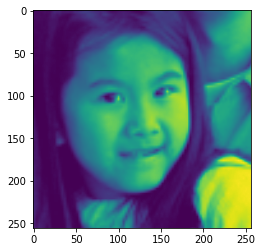

In [12]:
plt.imshow(test_images[0].sum(0).detach().cpu().numpy())
plt.show()

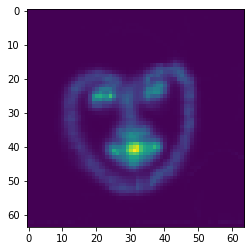

In [13]:
plt.imshow(HG[0].sum(0).detach().cpu().numpy())
plt.show()

In [106]:
res = imgs_with_mask(w300_test_image, w300_test_mask.toImage(256))

In [107]:
grid = make_grid(
            res[0:4], nrow=2, padding=2, pad_value=0, normalize=True, range=(-1, 1),
            scale_each=False)

In [108]:
grid_transpose = grid.permute(1,2,0)

In [109]:
w300_test_image_numpy = grid_transpose.cpu().numpy()

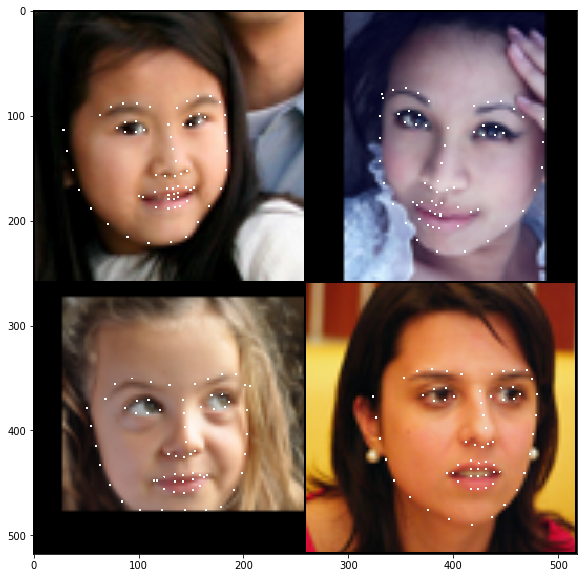

In [110]:
from matplotlib import pyplot as plt

plt.figure(figsize = (40,10))
plt.imshow(w300_test_image_numpy, interpolation='nearest')

In [111]:
res_transformed = g_transforms(image=w300_test_image, mask=w300_test_mask)
transformed_image, transformed_mask = res_transformed['image'], res_transformed['mask']
transformed_res = imgs_with_mask(transformed_image, transformed_mask.toImage(256))

In [112]:
grid = make_grid(
            transformed_res[0:4], nrow=2, padding=2, pad_value=0, normalize=True, range=(-1, 1),
            scale_each=False)

In [113]:
grid_transpose = grid.permute(1,2,0)

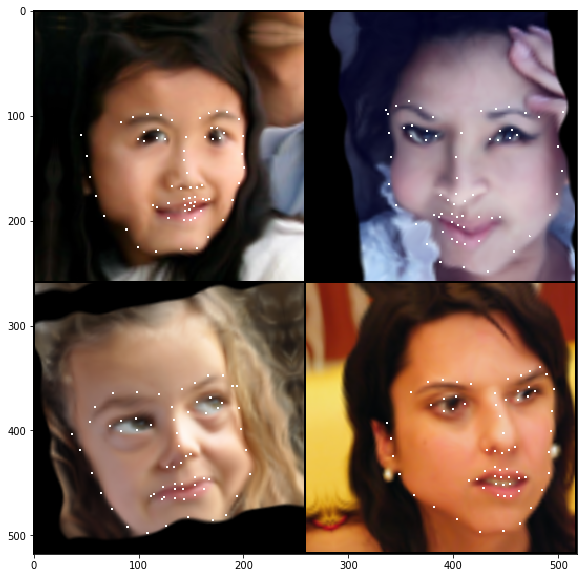

In [114]:
w300_test_image_numpy = grid_transpose.cpu().numpy()
plt.figure(figsize = (40,10))
plt.imshow(w300_test_image_numpy, interpolation='nearest')

In [115]:
heatmaper = ToHeatMap(64)

In [136]:
import math

def final_preds_untransformed(output, res):
    coords = get_preds(output) # float type

    # pose-processing
    for n in range(coords.size(0)):
        for p in range(coords.size(1)):
            hm = output[n][p]
            px = int(math.floor(coords[n][p][0]))
            py = int(math.floor(coords[n][p][1]))
            if px > 1 and px < res[0] and py > 1 and py < res[1]:
                diff = torch.tensor([hm[py - 1][px] - hm[py - 1][px - 2], hm[py][px - 1]-hm[py - 2][px - 1]], device=output.device)
                coords[n][p] += diff.sign() * .25
    coords += 0.5

    if coords.dim() < 3:
        coords = coords.unsqueeze(0)

    coords -= 1  # Convert from 1-based to 0-based coordinates

    return coords


def get_preds(scores):
    ''' get predictions from score maps in torch Tensor
        return type: torch.LongTensor
    '''
    assert scores.dim() == 4, 'Score maps should be 4-dim'
    maxval, idx = torch.max(scores.view(scores.size(0), scores.size(1), -1), 2)

    maxval = maxval.view(scores.size(0), scores.size(1), 1)
    idx = idx.view(scores.size(0), scores.size(1), 1) + 1

    preds = idx.repeat(1, 1, 2).float()

    preds[:,:,0] = (preds[:,:,0] - 1) % scores.size(3) + 1
    preds[:,:,1] = torch.floor((preds[:,:,1] - 1) / scores.size(3)) + 1

    pred_mask = maxval.gt(0).repeat(1, 1, 2).float()
    preds *= pred_mask
    return preds

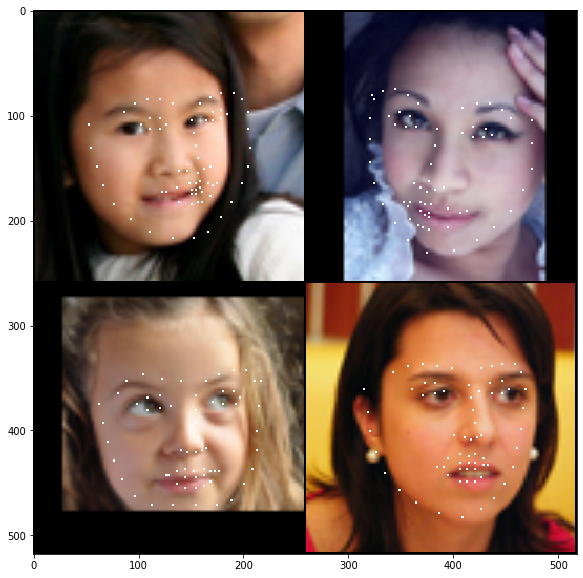

In [138]:
w300_test = next(iter(LazyLoader.w300().test_loader))
w300_test_mask = ProbabilityMeasureFabric(256).from_coord_tensor(w300_test["meta"]["keypts_normalized"][:8].to(device))
w300_test_mask = heatmaper.forward(w300_test_mask.probability, w300_test_mask.coord * 63)

coord = final_preds_untransformed(w300_test_mask, (64, 64)) / 64
coord = coord.cuda()
prob = torch.ones(8, 68) / 68
prob = prob.cuda()
maskkk = ProbabilityMeasure(prob, coord)
transformed_res = imgs_with_mask(w300_test_image, maskkk.toImage(256))
grid = make_grid(
            transformed_res[0:4], nrow=2, padding=2, pad_value=0, normalize=True, range=(-1, 1),
            scale_each=False)
grid_transpose = grid.permute(1,2,0)

w300_test_image_numpy = grid_transpose.cpu().numpy()
plt.figure(figsize = (40,10))
plt.imshow(w300_test_image_numpy, interpolation='nearest')


In [117]:
class NormalizeMask(albumentations.DualTransform):
    def __init__(self, dim):
        super(NormalizeMask, self).__init__(1)
        self.dim = dim

    def apply(self, img: torch.Tensor, **params):
        return img

    def apply_to_mask(self, img: torch.Tensor, **params):
        img = np.array(img)
        img[img<0]=0
        img = img / (img.sum(axis=self.dim, keepdims=True) + 1e-10)
        return img

In [118]:
g_transforms: albumentations.DualTransform = albumentations.Compose([
        ToNumpy(),
        NumpyBatch(ResizeMask(h=256, w=256)),
        NumpyBatch(albumentations.ElasticTransform(p=1, alpha=150, alpha_affine=1, sigma=10)),
        NumpyBatch(albumentations.ShiftScaleRotate(p=1, rotate_limit=10)),
        NumpyBatch(ResizeMask(h=64, w=64)),
        NumpyBatch(NormalizeMask(dim=(0,1,2))),
        ToTensor(device),
#         MaskToMeasure(size=256, padding=140, clu),
    ])

In [119]:
res_transformed = g_transforms(image=w300_test_image, mask=w300_test_mask)
transformed_image, transformed_mask = res_transformed['image'], res_transformed['mask']
# transformed_res = imgs_with_mask(transformed_image, transformed_mask.toImage(256))

In [126]:
coord, prob = heatmap_to_measure(w300_test_mask)
mes_mask = ProbabilityMeasure(prob, coord)

In [127]:
prob.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:3')

In [128]:
transformed_res = imgs_with_mask(transformed_image, mes_mask.toImage(256))


In [129]:
grid = make_grid(
            transformed_res[0:4], nrow=2, padding=2, pad_value=0, normalize=True, range=(-1, 1),
            scale_each=False)
grid_transpose = grid.permute(1,2,0)

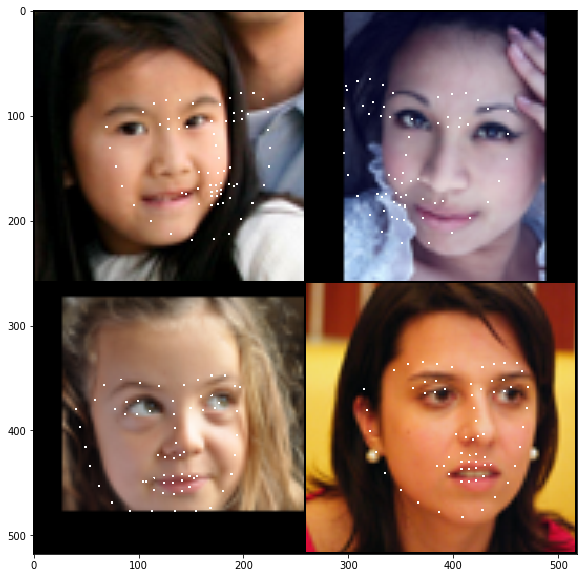

In [131]:
w300_test_image_numpy = grid_transpose.cpu().numpy()
plt.figure(figsize = (40,10))
plt.imshow(w300_test_image_numpy, interpolation='nearest')

In [180]:
import random

In [183]:
def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)
    
def sample_data(loader):
    while True:
        for batch in loader:
            yield batch

def content_to_measure(content):
    batch_size = content.shape[0]
    pred_measures: ProbabilityMeasure = ProbabilityMeasure(
            torch.ones(batch_size, 70, device=device) / 70,
            content.reshape(batch_size, 70, 2)
        )
    return pred_measures

def imgs_with_mask(imgs, mask, color=[1.0,1.0,1.0]):
    # mask = torch.cat([mask, mask, mask], dim=1)
    mask = mask[:, 0, :, :]
    res: Tensor = imgs.cpu().detach()
    res = res.permute(0, 2, 3, 1)
    res[mask > 0.00001, :] = torch.tensor(color, dtype=torch.float32)
    res = res.permute(0, 3, 1, 2)

    return res

def make_noise(batch, latent_dim, n_noise, device):
    if n_noise == 1:
        return torch.randn(batch, latent_dim, device=device)

    noises = torch.randn(n_noise, batch, latent_dim, device=device).unbind(0)

    return noises

def mixing_noise(batch, latent_dim, prob, device):
    if prob > 0 and random.random() < prob:
        return make_noise(batch, latent_dim, 2, device)

    else:
        return [make_noise(batch, latent_dim, 1, device)]



In [189]:
class Args:
    iter = 800000
    batch = 8
    n_sample = 64
    size = 256
    r1 = 10
    path_regularize = 2
    path_batch_shrink = 2
    d_reg_every = 16
    g_reg_every = 4
    mixing = 0.9
    ckpt = None
    lr = 0.002
    channel_multiplier = 1
    wandb = 'store_true'
    local_rank = 0
    image_size = 256
    batch_size = 8
    measure_size = 70 
    ct = 0.0001
    ca = 0.0002
    cw = 0.002
    ngf = 64
    ndf = 64 
    L1 = 2
    noise_size = 256.0
    input_dim = 3 
    dim = 16
    style_dim = 512 
    n_downsample = 2
    n_res = 4 
    activ = 'lrelu'
    pad_type = 'replicate'
    norm = 'none'
    mlp_dim = 256
    n_layer = 8
    num_scales = 1
    

munit_args=Args()

In [35]:
cont_style_encoder: MunitEncoder = cont_style_munit_enc(
        munit_args,
        None, # "/home/ibespalov/pomoika/munit_content_encoder15.pt",
        None  # "/home/ibespalov/pomoika/munit_style_encoder_1.pt"
    )

In [150]:
starting_model_number = 340000 
# weights = torch.load(f"/home/ibespalov/pomoika/stylegan2_invertable_{starting_model_number}.pt", map_location="cpu")
weights = torch.load(f"/home/ibespalov/pomoika/stylegan2_igor_2.pt", map_location="cpu")
cont_style_encoder.load_state_dict(weights['enc'])
cont_style_encoder = cont_style_encoder.to(device)

In [151]:
transform = albumentations.Compose(
        [
            albumentations.Resize(munit_args.size, munit_args.size),
            albumentations.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            AlbToTensor()
        ]
    )

    # dataset = ImageFolder("/raid/data/celeba", transform=transform)

dataset = ImageMeasureDataset(
    "/raid/data/celeba",
    "/raid/data/celeba_masks",
    img_transform=transform
)

loader = data.DataLoader(
    dataset,
    batch_size=1,
    sampler=data_sampler(dataset, shuffle=False, distributed=False),
    drop_last=True,
)

In [206]:
from gan.gan_model import CondStyleDisc2Wrapper, cont_style_munit_enc, CondStyleGanModel, CondGen2
from stylegan2.model import Generator
args.latent = 512
args.n_mlp = 5

args.start_iter = 0

generator = CondGen2(Generator(
    args.size, args.latent, args.n_mlp, channel_multiplier=args.channel_multiplier
))
generator.load_state_dict(weights['g'])
generator = generator.to(device)
noise1 = mixing_noise(args.batch, args.latent, args.mixing, device)
fake1, _ = generator(images_repeated, noise1)

In [198]:
fake1.shape

torch.Size([8, 3, 256, 256])

In [191]:
content.shape

torch.Size([1, 140])

In [195]:
images_repeated = for_gen_content.repeat(8,1) 
images_repeated.shape
# images_repeated = images_repeated.view(-1,input_size, sequence_length)

torch.Size([8, 140])

In [193]:
for_gen_content = cont_style_encoder.get_content(test_img)
for_gen_content

torch.Size([1, 140])

In [200]:
fake1 = fake1[0]

In [203]:
fake1.shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


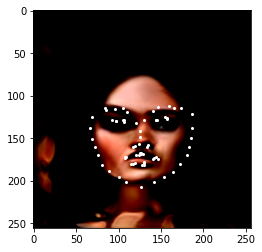

In [208]:
plt.imshow(fake1.detach().cpu().numpy()[0].transpose(1,2,0))
plt.scatter(y, x, s=4, marker='o', c='w')

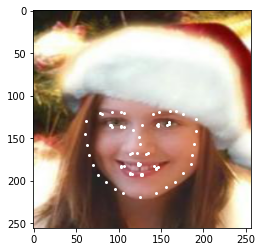

In [225]:
loader = sample_data(loader)
test_img, test_mask = next(loader)
test_img = test_img.cuda()
test_mask = test_mask.cuda()
content, latent = cont_style_encoder(test_img)
test_img = (test_img + 1) / 2
pred_measures: ProbabilityMeasure = content_to_measure(content)
x = np.around((pred_measures.coord[0,:,0] * 256).detach().cpu().numpy())
y = np.around((pred_measures.coord[0,:,1] * 256).detach().cpu().numpy())
plt.imshow(test_img.detach().cpu().numpy()[0].transpose(1,2,0))
plt.scatter(y, x, s=4, marker='o', c='w')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


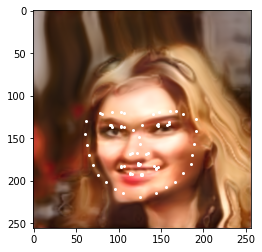

In [228]:
images_repeated = content.repeat(8,1) 
noise1 = mixing_noise(args.batch, args.latent, args.mixing, device)
fake1, _ = generator(images_repeated, noise1)
plt.imshow(((fake1.detach().cpu().numpy()[0] + 1) / 2).transpose(1,2,0))
plt.scatter(y, x, s=4, marker='o', c='w')

In [213]:
fake1[0].max()

tensor(1.1482, device='cuda:2', grad_fn=<MaxBackward1>)

In [146]:
test_img.max()

tensor(1., device='cuda:2')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


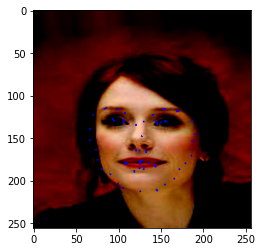

In [121]:
iwm = imgs_with_mask(test_img, pred_measures.toImage(256), color=[0, 0, 1])
iwm = iwm.numpy()[0].transpose(1,2,0)
plt.imshow(iwm)